## Distance_horizon_estimate_py3

Aim of this code is to get analytical estimates of distance horizon for a) Stochastic, b) Matched Filter (MF) and c) Semi- Coherent (SC) limits. This code was developed by Tanazza Khanam, member of the Cross-Correlation Algorithm (CoCoA) team led by Alessandra Corsi. If you have used this code or any other scripts that are part of the CoCoA package for a project that leads to a scientific publication or public presentation, please acknowledge this by citing the following papers:

- Coyne, Corsi, Owen 2016, https://ui.adsabs.harvard.edu/abs/2016PhRvD..93j4059C/abstract (referred as CCO hereafter)
- Sowell, Corsi, Coyne 2019, https://ui.adsabs.harvard.edu/abs/2019PhRvD.100l4041S/abstract 




### Code Summary:

- Code intakes a waveform file, run parameters, statistic and timinig parameter inputs given in corresponding .ini file. 
- First it calculates constant guassian PSD value also called white noise using the a particular detector's sensitivity curve. 
- Next it calculates detection statistics mean value, sigma and hrms_input for above gaussian (constant) PSD value. 
- Compares the same calculations with their corresponding detection threshold limits for Stochastic, MF and SC cases. 
- Further use that to calculate distance horizon for an injected input distance for each case.
- Lastly, calculate the hrms_min values over a range of FAP to reproduce Fig-5 from CCO for comparison.

### How to run this code
- The .ipynb can be run in Jupiter Notebook and has been tested to work on https://jupyter.ligo.caltech.edu.
- The .py version can be run from command line via "python Distance_horizon_estimate.py --config Distance_horizon_estimate.ini --num_of_waveform 0" and has been tested to work on the CIT resources of the LDG.
- The .py version of this code is generated via the final command line "!jupyter nbconvert --to script Distance_horizon_estimate.ipynb" in the .ipynb version. Thus, the two versions of this code mirror exactly each other. Any modifications to the code MUST be made in the .ipynb version of it (since it's a lot easier to work on it), and then trasferred identically to the .py simply by running the .ipynb itself. This also guarantees that you are making modifications that actually work: if the .ipynb does not run properly up to the final line where it translates itself into a .py version, it means the modifications you made have bugs!

### Inputs of the code begin here

### 1) Importing python dependencies
In the block below we import the necessary python modules. Make sure you are running this code under python3 and with these packages already installed.

In [1]:
import numpy as np
import cmath
from tqdm import trange as tnrange
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from scipy import special
from numpy import trapz
from scipy.stats import ncx2, chi2
import argparse
import configparser
import sys
import os
import datetime

### 2) Tracking time for code
To keep track of how long the code takes to run, below we print the date and time of when this code starts running and define it as tick1. 

In [2]:
tick1 = datetime.datetime.now()
print("..........................")
print('Starting to run on ',tick1.strftime("%Y-%m-%d-%H:%M:%S"))
print("..........................")
print(" ")
print(" ")

..........................
Starting to run on  2022-09-07-15:20:15
..........................
 
 


### 3) Parsing the Distance_horizon_estimate.ini file
Below we use the argparse python module to pass to Distance_horizon_estimate (this code) the necessary inputs from Distance_horizon_estimate.ini (configuration file) and number of waveforms to run at. We use a configuration file because there are several inputs we need to provide to Distance_horizon_estimate, and saving them all in a single .ini file helps with bookeeping. Note that the .ini file MUST be named Distance_horizon_estimate.ini. This file MUST be saved in the same directory where you run Distance_horizon_estimate.py or Distance_horizon_estimate.ipynb. 


The first step in using the argparse is creating an ArgumentParser object, which we call parser here.

Then, we fill the ArgumentParser with information about the arguments we need (i.e. the name of the .ini file) by using the add_argument() method. This tells the ArgumentParser how to take the string we provide on the command line and turn various parts of that string into objects. Specifically, we need to tell the ArgumentParser that what follows the --config in the command line is the name of the file we need to use as configuration file. These instructions are stored and used when parse_args() is called later on. Similary, add_argument() method for number of waveform input

**Note that if no configuration file is passed via command line, or if the .ipynb version of this code is run (see Section 4), the code will search for a 'Distance_horizon_estimate.ini' file in the working directory and automatically use that as configuration file.**

In [3]:
parser = argparse.ArgumentParser()
parser = argparse.ArgumentParser(description='Use this code to get analytical estimates of distance horizon for Stochastic, Matched Filter (MF) and Semi- Coherent (SC) limits')
parser.add_argument('--config',type=str,required=False,help='The path to an .ini file which configures the various inputs for Distance_horizon_estimate code. The name of the .ini file needs to be provided following the --config option.', default='Distance_horizon_estimate.ini')
parser.add_argument('--num_of_waveform',type=int, required=False, help='Provide the name of the wavefrom name listed/placed at waveformpath defined in .ini file ', default=0)
print('The system command line arguments are set to:',sys.argv)
print("..........................")
print(" ")
print(" ")

The system command line arguments are set to: ['/home/tanazza.khanam/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '-f', '/home/tanazza.khanam/.local/share/jupyter/runtime/kernel-bbc65289-d28b-4d6f-b369-b257ac8836bf.json']
..........................
 
 


### 4) Command line versus jupyter notebook run: setting the sys.argv array correctly 
The if else statement below takes care of setting the sys.argv array correctly (depending on whether we are running via command line or jupyter notebook) **before** the args = parser.parse_args() command tells argparse to read the sys.argv array itself and interpret it as described in the parser.add_argument command above. 

When running Distance_horizon_estimate.py via command line ones types in a shell:
- python Distance_horizon_estimate.py --config Distance_horizon_estimate.ini --num_of_waveform 0

The above command line has the following effect on the sys.argv list:
- The code name 'Distance_horizon_estimate.py' gets saved as a string into the first element sys.argv[0] of the sys.argv list;
- The '--config' gets saved as a string into the second element sys.argv[1] of the sys.argv list;
- The name of the ini file 'Distance_horizon_estimate.ini' gets saved in the thrid element sys.argv[2] of the sys.argv list;
- The '--num_of_waveform' gets saved as a string into the second element sys.argv[3] of the sys.argv list;
- The number 0 (default for 1 waveform) gets saved in the thrid element sys.argv[4] of the sys.argv list.

The above sys.argv list can be interepreted correctly without modifications when calling the parser (thanks to the instructions we provided above via the parser.add_argument).

When running Distance_horizon_estimate.py in a jupyter notebook (rather than via command line), however, the sys.argv array gets messed up. Specifically, in jupyter the sys.argv[0] will read something like /home/tanazza.khanam/.local/lib/python3.6/site-packages/ipykernel_launcher.py and the sys.argv[1] will typically be set to '-f'. Thus, we use the following trick to make Distance_horizon_estimate.py work in jupyter without modifications: 
- We reset all elements in the sys.argv list to null values;
- Because setting sys.argv to a null string is equivalent to not passing any --config option, the parser sets the .ini file and number of waveform equal to their respective default values (declared above via the ArgumentParser as being equal to Distance_horizon_estimate.ini and 0 respectively).

In [4]:
if sys.argv[0] == '/home/tanazza.khanam/Distance_Estimate_Test/Distance_horizon_estimate.py':
    args = parser.parse_args()
    print('The command line arguments I am taking are: ' , str(sys.argv), 'please make sure this is correct!')
else:
    sys.argv = ['']
    args = parser.parse_args()
    print('Since this code does not apper to be run via command line, I am passing the default Distance_horizon_estimate.ini and number of waveforms 0 (zero) as inputs.')
print("..........................")
print(" ")    

Since this code does not apper to be run via command line, I am passing the default Distance_horizon_estimate.ini and number of waveforms 0 (zero) as inputs.
..........................
 


Next, we read in all parameter values from the .ini configuration file using configparser. 

In [5]:
num_of_waveform = int(args.num_of_waveform)
config_file = args.config
Config = configparser.ConfigParser(os.environ)
Config.read(config_file)
# print(num_of_waveform)

['Distance_horizon_estimate.ini']

### 5) Input computing/waveform/sensitivity parameters 
We first read the inputs saved under the "ComputingParameters", "TemplateParameters" and "SensitivityParameters" section of the .ini file. These are:
- **BasePath**: This is the path to the directory where this code is being run (i.e., the output you get if you type pwd in the directory where you have saved this code). Example: /home/tanazza.khanam/Distance_Estimate_Test/. 

- **WaveformFolder**: This is the directory name which consists of waveform(s). 

- **WaveformName**: This is the name of the waveform over which this code will do calculations on.

- **PathToSensiCurve**: This is the sensitivity curve directory placed within WaveformFolder.

- **SensiCurveName**: This is the Sensitivity curve with which we would calculate the constant Gaussian PSD.

In [6]:
basepath = Config.get('ComputingParameters', 'BasePath')
waveformfolder = Config.get('TemplateParameters', 'WaveformFolder')
waveformlistfilename = Config.get('TemplateParameters', 'WaveformlistFilename' )
waveformlist = basepath+waveformlistfilename
waveformpath = waveformfolder
#waveformname = Config.get('TemplateParameters','Waveform')
# wvfrmlist_filename = np.loadtxt(waveformlistfilename, dtype=str)
#print(wvfrmlist_filename)
wvfrmlist_filename = np.genfromtxt(waveformlist, dtype=str)
print("List of waveforms: ", wvfrmlist_filename)
print("..........................")
waveformname = wvfrmlist_filename[int(num_of_waveform)]
waveformfile = waveformpath+waveformname
print("Waveform selected: ", waveformname)
print("..........................")
Sensicurvefolder = Config.get('SensitivityParameters','SensiCurveFolder')
Sensicurvepath = basepath+Sensicurvefolder
Sensicurvename = Config.get('SensitivityParameters','SensiCurveName')
Sensicurvefile = Sensicurvepath+Sensicurvename
# print(Sensicurvepath)
# wvfrm = np.loadtxt(waveformfile)
print(" ")
print(" ")

List of waveforms:  [ 'C-0.41200000M2.5999999MsunR12.060000kmB3.0100000e14_h_cut165.00000_nospace.txt'
 'C-0.41200000M2.5999999MsunR13.260000kmB4.9200000e14_h_cut165.00000_nospace.txt'
 'C-0.41200000M2.5999999MsunR13.620000kmB4.1700000e14_h_cut165.00000_nospace.txt'
 ...,
 'C-0.41200000M2.5999999MsunR12.280000kmB3.5300000e14_h_cut165.00000_nospace.txt'
 'C-0.41200000M2.5999999MsunR13.400000kmB4.3300000e14_h_cut165.00000_nospace.txt'
 'C-0.41200000M2.5999999MsunR12.560000kmB4.5800000e14_h_cut165.00000_nospace.txt']
..........................
Waveform selected:  C-0.41200000M2.5999999MsunR12.060000kmB3.0100000e14_h_cut165.00000_nospace.txt
..........................
 
 


### 6) Input Run/Timing/Statistical/Output parameters 
We next read the inputs saved under the "RunParameters", "TimingParameters", "StatisticalParameters" and "OutputParameters" section of the .ini file. These are:
- **F_x_H/F_x_L and F_p_H/F_p_L**: This is cross(x) and plus(p) antenna factors for the LH and LL detector respectively.

- **T_sft**: This is SFT baseline which determines number of SFTs over the chosen duration of waveform. 

- **f_s**: This is the sample frequency which is used to resample the waveform at desired frequency keeping nyquist limit in mind.

- **lumdist**: This is the injected luminosity distance.

- **A_p/A_x**: These are amplitude factors for plus and cross modes of GW.

In [7]:
# RunParameters
F_x_H = float(Config.get('RunParameters', 'F_x_H'))
F_x_L = float(Config.get('RunParameters', 'F_x_L'))
F_p_H = float(Config.get('RunParameters', 'F_p_H'))
F_p_L = float(Config.get('RunParameters', 'F_p_L'))
T_sft = float(Config.get('RunParameters', 'T_sft'))
f_s = float(Config.get('RunParameters', 'samplefreq'))
lumdist = float(Config.get('RunParameters', 'lumdistance'))
A_p = float(Config.get('RunParameters', 'A_p'))
A_x = float(Config.get('RunParameters', 'A_x'))
num_det=int(Config.get('RunParameters', 'num_det'))


# StatisticalParameters
FAP = float(Config.get('StatisticalParameters', 'FAP'))
FDP = float (Config.get('StatisticalParameters', 'FDP'))

# TimingParameters

start_time = float(Config.get('TimingParameters', 'start_time'))
t_signal = float(Config.get('TimingParameters', 'signal_duration'))

# OutputParameters
Plot_parameter = str(Config.get('OutputParameters','Plot_parameter'))
outputfoldername = Config.get('OutputParameters','OutputFolder')
outputpath = basepath+outputfoldername
outputfilename = Config.get('OutputParameters','OutputFilename')
outputfile = outputpath+outputfilename


Loading the waveform file. Here we could've have used panda for faster run of the cell but this is a bargain between using pandas to load files vs avoiding to add one more dependency to the code to keep it simple.

In [8]:
print("Beginning to load the waveform file. This step is the most timing consuming dependending on the size of waveform.")
print("..........................")
wvfrm = np.loadtxt(waveformfile)
print(" ")
print(" ")

Beginning to load the waveform file. This step is the most timing consuming dependending on the size of waveform.
..........................
 
 


Loading Sensitivity curve files

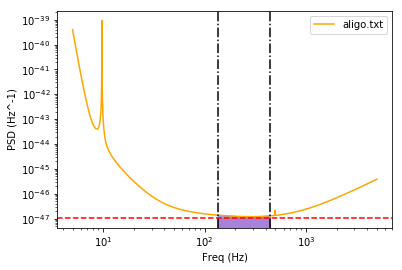

Gaussian_approx_PSD_adjusted : 1.05063098203e-47
..........................
 
 


In [9]:
Sensi_curve = np.loadtxt(Sensicurvefile)

freq = Sensi_curve[:,0]
amp = Sensi_curve[:,1]
PSD = amp**2

#Calculating PSD from minimum freq of waveform to maximum freq of waveform. Note: Sensitivity curve freq range
#could be much larger than that of waveform as it is freq range of detector

wvfrm_freq = wvfrm[:,1]
PSD_integrate = PSD[np.where(freq>=wvfrm_freq.min())[0][0]: np.where(freq>=wvfrm_freq.max())[0][0]]
freq_integrate = freq[np.where(freq>=wvfrm_freq.min())[0][0]: np.where(freq>=wvfrm_freq.max())[0][0]]
area_under_f1_f2_integrate_trapz = trapz(PSD_integrate,freq_integrate)
Gaussian_approx_PSD = area_under_f1_f2_integrate_trapz/(wvfrm_freq.max()-wvfrm_freq.min())

#Compensation PSD for spectal leakage such that taking only 85% of it and hence multiplying by 0.85 below to adjust PSD
Gaussian_approx_PSD_adjusted = Gaussian_approx_PSD*0.85 

plt.loglog(freq, PSD, 'orange', label = '{:}'.format(Sensicurvename))
plt.axvline(x = freq_integrate.min() , color = 'black', linestyle = '-.')
plt.axvline(x = freq_integrate.max(), color = 'black', linestyle = '-.')
plt.axhline(y = Gaussian_approx_PSD_adjusted, color = 'red', linestyle = '--')
plt.fill_between(freq_integrate, PSD_integrate, color = "blue",alpha = 0.4)
plt.fill_between(freq_integrate, Gaussian_approx_PSD_adjusted, color = "red",alpha = 0.15)
# plt.ylim(1e-47, 1e-43)
# plt.xlim(1e1, 1e+3)
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD (Hz^-1)")
plt.legend()
plt.show()
print('Gaussian_approx_PSD_adjusted :',Gaussian_approx_PSD_adjusted)
print("..........................")
print(" ")
print(" ")

In [10]:
print( "You have picked:")
print("F_p_L = " , F_p_L, ", F_x_L = ", F_x_L, ", F_p_H = ", F_p_H, "and F_x_H = ", F_x_H)
print('T_sft = ', T_sft)
print('Sample frequency = ', f_s, 'Hz')
print('Injected distance = ', lumdist, 'Mpc ')
print('FAP = ', FAP )
print('FDP = ',  FDP )

#picking the start time value from waveform which is closest to given input start time 

if start_time == 0:
    t_start = wvfrm[:,0][0]
    start = int(t_start)
    print('start = ', start)
else:
    start = wvfrm[:,0][np.where(wvfrm[:,0] >=start_time)[0][0]]
    print('start = ', start)


if t_signal != 0.0 :
    print('signal duration = ', t_signal)
else: 
    t_signal = np.floor(max(wvfrm[:,0])-min(wvfrm[:,0]))
    print('signal duration = ', t_signal)

stop = int(start+t_signal)

#Making sure that stop time does not exceed the stop time of waveform
if stop > np.floor(max(wvfrm[:,0])-min(wvfrm[:,0])) :
    stop = wvfrm[:,0][-1]
print ("t_signal: ", t_signal,"start: ", start,"stop: ", stop)
print("..........................")
print(" ")
print(" ")

You have picked:
F_p_L =  1.0 , F_x_L =  0.0 , F_p_H =  1.0 and F_x_H =  0.0
T_sft =  0.25
Sample frequency =  4096.0 Hz
Injected distance =  15.0 Mpc 
FAP =  0.01
FDP =  0.5
start =  0
signal duration =  165.0
t_signal:  165.0 start:  0 stop:  165
..........................
 
 


**Calculation part of the code begins**

In [11]:
#Calculation part of the code


#Calculating G_ij from Equation 4.6 Coyne et al 
#Note that we are performing it strictly for Stochastic case with A+/Ax =1 and I, J coming from different detectors at coincidental times.
delta_phi_IJ = np.arctan(-(F_x_H/F_p_H)) - np.arctan(-(F_x_L/F_p_L))
G_IJ = np.sqrt((A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2))*np.exp(complex(0,-delta_phi_IJ))/4
print("G_IJ: ",G_IJ)
print(" ")

G_IJ:  (0.25+0j)
 


In [12]:
#Equation 4.4 Coyne et al

#initialising U_IJ
U_IJ=0
#Fixing PSDs
S_n_H = S_n_L = S_n = Gaussian_approx_PSD_adjusted #1.4445165765542899e-47  # Set to value given by Rob for Fig-5   # 5.8e-47 was value given by Eric 

sigma_sqr_IJ = S_n_H*S_n_L/(4*T_sft**2)
print("sigma_sqr_IJ: ",sigma_sqr_IJ)
print(" ")
#Equation 4.12 Coyne et al

#Since I=J, if I comes from LL, J must come from LH
U_IJ = np.exp(complex(0,delta_phi_IJ))*np.sqrt((A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2))*(T_sft**2)/S_n**2 
print("U_IJ: ", U_IJ)
print(" ")


sigma_sqr_IJ:  4.41530184161e-94
 
U_IJ:  (5.66212705197e+92+0j)
 


In [45]:
#Equation 4.14 Coyne et al

#resampling time at 1/f_s rate
time_track = np.arange(start, stop, f_s**-1) 

#interpolating corresponding frequencies
freq = np.interp(time_track, wvfrm[:,0], wvfrm[:,1]) 

#calculating phase from those new sampled freq and time track
phase = np.concatenate([np.array([0]), 2*np.pi*cumtrapz(freq, x=time_track)]) 

#interpolating corresponding amplitudes 
#apmlitude is modified so as to measure at lumdist. Also adjusting the units 1e-21
h_amp = np.interp(time_track, wvfrm[:,0], (100/lumdist)*1e-21*wvfrm[:,2]) 
# print((h_amp))


In [14]:
#Defining num_sfts for Stochastic case 

num_sft_stoch = {}
num_sft_stoch = int((stop-start)/T_sft)


# eqn 3.16 for 'LH' i.e. getting ampltitude at resampled time/freq data points
h_t_H = (h_amp*A_p*F_p_H*np.cos(phase)) + (h_amp*A_x*F_x_H*np.sin(phase)) 
# eqn 3.16 for 'LL' i.e. getting ampltitude at resampled time/freq data points
h_t_L = (h_amp*A_p*F_p_L*np.cos(phase)) + (h_amp*A_x*F_x_L*np.sin(phase)) 


h_f_L = {} #defining array going to store fft for each T_sft length for LL
h_f_H = {} #defining array going to store fft for each T_sft length for LH
rho = 0  #initializing rho from eqn 4.14 CCO
com_con_h_f_H = {} #defining array going to store complex conjugate of fft for each T_sft length for LH

h_f_sum = 0 # initializing of what is going to store equivalent of {} quantity in equantion 4.14 CCO 
counter = 0
for i in tnrange(num_sft_stoch):
  h_f_L[i] = (np.fft.rfft(h_t_L[int(i*f_s*T_sft):int((i+1)*f_s*T_sft)])[1:-1])/f_s 
  h_f_H[i] = (np.fft.rfft(h_t_H[int(i*f_s*T_sft):int((i+1)*f_s*T_sft)])[1:-1])/f_s 
  com_con_h_f_H[i] = np.ndarray.conjugate(h_f_H[i])
  for j in range(len(com_con_h_f_H[i])):
    h_f_sum =  h_f_sum +(U_IJ*com_con_h_f_H[i][j]*h_f_L[i][j])
    counter = counter+1
#print (h_f_sum)    
print('num_sft_stoch for chosen duration =', num_sft_stoch)
print(" ")
#print ('Some checks for iterations: ', num_sft_stoch*len(com_con_h_f_H[i]), counter)
rho = (2*h_f_sum.real)/(T_sft**2)
print('rho value from 4.14 CCO is', rho)
print(" ")

100%|██████████| 660/660 [00:00<00:00, 1142.50it/s]

num_sft_stoch for chosen duration = 660
 
rho value from 4.14 CCO is 2.75303182811e+49
 


In [39]:
#Equation 4.17 Coyne et al
mean_rho = 0.0
amp_new = [] 
time_new = []
#now calcuate the times and amplitudes at the center of each time-resampled bin
for i in range(num_sft_stoch):
    amp_new = np.append(amp_new,h_amp[int((i+0.5)*T_sft*f_s)]) 
    time_new = np.append(time_new,time_track[int((i+0.5)*T_sft*f_s)]) 
# print(amp_new)
power = (amp_new)**2
# print((power))
#Equation 4.17 Coyne et al
mean_rho = ((T_sft**2/2.)*(A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2)/(S_n**2))*np.sum(power)
print('mean rho calculated from 4.17 CCO  =', mean_rho)
print(" ")

mean rho calculated from 4.17 CCO  = 2.75307223121e+49
 


In [40]:
#Equation 4.18 Coyne et al
rho_sigma = ((T_sft**2/2.)*(A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2)/(S_n**2)*num_sft_stoch)**(0.5) 
print('sigma rho =',rho_sigma)
print(" ")

sigma rho = 4.32261717846e+47
 


In [41]:
#Equation 4.24 Coyne et al
hrms_input = (np.sum(power)/num_sft_stoch)**(0.5)
print('hrms_input = ', hrms_input) 
print(" ")

hrms_input =  1.21384162976e-23
 


In [18]:
#Equation 4.18 Coyne et al
rho_sigma = ((T_sft**2/2.)*(A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2)/(S_n**2)*num_sft_stoch)**(0.5) 
print('sigma rho =',rho_sigma)


sigma rho = 4.32261717846e+47


In [19]:
#Equation 4.24 Coyne et al
hrms_input = (np.sum(power)/num_sft_stoch)**(0.5)
print('hrms_input = ', hrms_input) 
print(" ")

hrms_input =  1.21384162976e-23
 


In [20]:
#Equation 4.22 Coyne et al 
S = special.erfcinv(2.0*FAP)-special.erfcinv(2.0*(1.0-FDP)) #Detection limit for Stochastic 

#print the SNR threshold for detection
SNR_thr=S*(2.0)**(0.5) #Notice it is being multiplied by sqrt2

print('SNR_thr=', SNR_thr) 
print(" ")

SNR_thr= 2.32634787404
 


In [21]:
#Following Eq. 4.23 of Coyne et al. to caclualte the minimum detectable hrms
hrms_min_Stoch = ((2.0)**0.5*S**0.5*T_sft**(-0.5)*num_sft_stoch**(-0.25)*S_n**(0.5))/((A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2))**0.25
print('hrms_min_Stoch = ', hrms_min_Stoch)
print(" ")

hrms_min_Stoch =  2.31987156407e-24
 


In [22]:
#Maximum distance for detection
distance_max_Stoch  = lumdist*(hrms_input/hrms_min_Stoch)
print('maximum distance for Stochastic limit = ', distance_max_Stoch) 
print(" ")

maximum distance for Stochastic limit =  78.4854848361
 


**Code Output begins**

In [23]:
#Code Output:
print(".........Printing Output for Stochastic Limit...........")
print('rho value from 4.14 CCO is',rho)
print('mean rho from 4.17 CCO is', mean_rho)
ratio=mean_rho/rho
print('ratio_rho = ',ratio)

#print input waveform SNR
SNR = mean_rho/rho_sigma
print('SNR=',SNR)
print('SNR_thr=', SNR_thr) 

print('hrms_input = ', hrms_input)
print('hrms_thr_Stoch =', hrms_min_Stoch)
print('hrms_ratio = ',(hrms_input/hrms_min_Stoch))

#Stoch Limit for distance estimate
print('input_distance = ', lumdist, 'Mpc')
print('distance_max_Stoch = ', distance_max_Stoch,  'Mpc')
print('distance_ratio_Stoch =', lumdist/distance_max_Stoch)
print(" ")
print(" ")


.........Printing Output for Stochastic Limit...........
rho value from 4.14 CCO is 2.75303182811e+49
mean rho from 4.17 CCO is 2.75307223121e+49
ratio_rho =  1.00001467586
SNR= 63.6899387004
SNR_thr= 2.32634787404
hrms_input =  1.21384162976e-23
hrms_thr_Stoch = 2.31987156407e-24
hrms_ratio =  5.23236565574
input_distance =  15.0 Mpc
distance_max_Stoch =  78.4854848361 Mpc
distance_ratio_Stoch = 0.191118141543
 
 


In [24]:
#MF Limit for distance estimate
n_coh_MF=1
dof =2*n_coh_MF
hrms_min_MF = 0.

# Pass array of non-centrality parameters to UNSCALED NCX2 CDF
# Calculate absolute value of difference from FDP
ncp_range = np.linspace(0,25*n_coh_MF,10000)
diff_from_fdp = np.abs(ncx2.cdf(chi2.ppf(1-FAP, dof), dof, nc=ncp_range)-FDP)
#print(diff_from_fdp.min())

# Find index of closest value to FDP
ncp_idx = np.where(diff_from_fdp==np.nanmin(diff_from_fdp))
ncp = ncp_range[ncp_idx][0]
#print(ncp_idx,ncp_range[ncp_idx])


# Calculates and returns the hrms value based on Eq. (4.35) / Eq. (4.37)
hrms_min_MF = np.sqrt(ncp*S_n/(int(stop - start)*num_det*(A_p**2*F_p_H**2+A_x**2*F_x_H**2))) #num_det =2 (passed in inputs)


#Maximum distance for detection MF limit
print(".........Printing Output for Matched Filter Limit...........")
print('hrms_min_MF = ', hrms_min_MF)
print('input_distance = ', lumdist, 'Mpc')
distance_max_MF = lumdist*(hrms_input/hrms_min_MF)
print('distance_max_MF = ', distance_max_MF, 'Mpc')
print('distance_ratio_MF =', lumdist/distance_max_MF)
print(" ")
print(" ")

.........Printing Output for Matched Filter Limit...........
hrms_min_MF =  5.10659950179e-25
input_distance =  15.0 Mpc
distance_max_MF =  356.550860116 Mpc
distance_ratio_MF = 0.0420697344415
 
 


In [25]:
#SC Limit for distance estimate
n_coh_SC=512
dof =2*n_coh_SC
hrms_min_SC = 0.

# Pass array of non-centrality parameters to UNSCALED NCX2 CDF
# Calculate absolute value of difference from FDP
ncp_range = np.linspace(0,25*n_coh_SC,10000)
diff_from_fdp = np.abs(ncx2.cdf(chi2.ppf(1-FAP, dof), dof, nc=ncp_range)-FDP)

# Find index of closest value to FDP
ncp_idx = np.where(diff_from_fdp==np.nanmin(diff_from_fdp))
ncp = ncp_range[ncp_idx][0]

hrms_min_SC = np.sqrt(S_n*ncp/(int(stop - start)*(A_p**2*F_p_H**2+A_x**2*F_x_H**2)*num_det)) #num_det =2 (passed in inputs)


#Maximum distance for detection SC limit
print(".........Printing Output for Semi Coherent Limit...........")
print('hrms_min_SC = ', hrms_min_SC)
print('input_distance = ', lumdist, 'Mpc')
distance_max_SC = lumdist*(hrms_input/hrms_min_SC)
print('distance_max_SC =', distance_max_SC, 'Mpc')
print('distance_ratio_SC =', lumdist/distance_max_SC)
print(" ")
print(" ")

.........Printing Output for Semi Coherent Limit...........
hrms_min_SC =  1.8612482196e-24
input_distance =  15.0 Mpc
distance_max_SC = 97.8248051745 Mpc
distance_ratio_SC = 0.153335342434
 
 


In [26]:
print("....Saving useful output in file at {:}.....".format(Sensicurvepath)+"PSD_Stoch_MF_SC_distances.txt")
file1 = open("{:}".format(Sensicurvepath)+"PSD_Stoch_MF_SC_distances.txt", "a")
#file1 = open("myfile.txt", "a")  # append mode
file1.write("\n")
file1.write("{:} {:} : ".format(Sensicurvename[:-4], waveformname[:-4]))
file1.write("\n")
file1.write("Gaussian_approx_PSD_adjusted: ")
file1.write(str(Gaussian_approx_PSD_adjusted))
file1.write("\n")
file1.write("distance_max_Stoch: ")
file1.write(str(distance_max_Stoch))
file1.write("\n")
file1.write("distance_max_SC: ")
file1.write(str(distance_max_SC))
file1.write("\n")
file1.write("distance_max_MF: ")
file1.write(str(distance_max_MF))
file1.write("\n")
file1.close()
print(" ")

....Saving useful output in file at /home/tanazza.khanam/Distance_Estimate_Test/curves_Jan_2020/.....PSD_Stoch_MF_SC_distances.txt
 


**Plotting Figure 5 from Coyne et al  https://arxiv.org/pdf/1512.01301.pdf**

In [27]:
if Plot_parameter == 'True': 
  #Stochastic Limit: Figure-5 in remaking

  FAP_values = np.logspace(-5, 0, 100)
  S_Stoch=np.ones(len(FAP_values))
  hrms_min_Stoch=np.ones(len(FAP_values))
  for i in tnrange(len(FAP_values)):
    S_Stoch[i] = special.erfcinv(2.0*FAP_values[i])-special.erfcinv(2.0*(1.0-FDP)) #detection condition
    hrms_min_Stoch[i] = (((2.0)**0.5*S_Stoch[i]**0.5*T_sft**(-0.5)*num_sft_stoch**(-0.25)*S_n**(0.5))/((A_p**2*F_p_H**2+A_x**2*F_x_H**2)*(A_p**2*F_p_L**2+A_x**2*F_x_L**2))**0.25)
  #print((S_Stoch[-1]),hrms_min_Stoch[-1], FAP_values[-1])


  #Matched Filter/Semi-Coherent Limit: Figure-5 in remaking

  hrms_min_SC= {}
  for n_coh_SC in [1, 64, 512] :
    hrms_min_SC[n_coh_SC]={}
    for i in tnrange(len(FAP_values)):
      dof =2*n_coh_SC
      # Pass array of non-centrality parameters to UNSCALED NCX2 CDF
      # Calculate absolute value of difference from FDP
      ncp_range = np.linspace(0,25*n_coh_SC,10000)
      diff_from_fdp = np.abs(ncx2.cdf(chi2.ppf(1-FAP_values[i], dof), dof, nc=ncp_range)-FDP)
      
      # Find index of closest value to FDP
      ncp_idx = np.where(diff_from_fdp==np.nanmin(diff_from_fdp))
      ncp = ncp_range[ncp_idx][0]

      # Calculates and returns the hrms value based on Eq. (4.35) / Eq. (4.37)
      hrms_min_SC[n_coh_SC][i] = np.sqrt(ncp*S_n/(int(stop - start)*num_det*(A_p**2*F_p_H**2+A_x**2*F_x_H**2)))
      #print(hrms_min_SC[i], FAP_values[i], ncp ) 
#     print(len(hrms_min_SC), hrms_min_SC[n_coh_SC])

hrms_min_MF = list(hrms_min_SC[1].values())
hrms_min_SC_64 = list(hrms_min_SC[64].values())
hrms_min_SC_512 =list(hrms_min_SC[512].values())  

100%|██████████| 100/100 [00:01<00:00, 75.87it/s]


........Saving plot at /home/tanazza.khanam/Distance_Estimate_Test/Fig_5_Plots/Fig_5_CCO.png
 


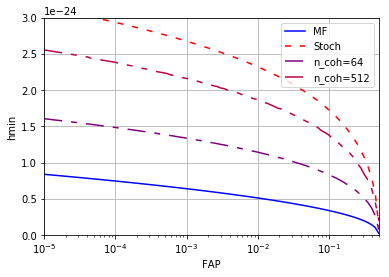

In [28]:
if Plot_parameter == 'True':
    print ("........Saving plot at {:}".format(outputfile))
    print(" ")
  #Plotting Figure-5

    plt.semilogx(FAP_values, hrms_min_MF, 'b', ls='-', label = 'MF')
    plt.semilogx(FAP_values, hrms_min_Stoch, 'r', dashes=[4,6], label = 'Stoch')
    plt.semilogx(FAP_values, hrms_min_SC_64, '#7f007f', dashes=[12,6,4,6], label = 'n_coh=64')
    plt.semilogx(FAP_values, hrms_min_SC_512, '#bf003f', dashes=[12,6,4,6,4,6], label = 'n_coh=512')

    plt.grid(True)
    plt.xlabel("FAP")
    plt.xlim(1e-5,0.5)
    plt.ylabel("hmin")
    plt.ylim(0, 3.0e-24)
    plt.legend(loc= 'upper right')
    plt.savefig(outputfile)

    plt.show()

In [29]:
tick2 = datetime.datetime.now()
print('Ending run on ',tick2.strftime("%Y-%m-%d-%H:%M:%S"))
print(" ")

Ending run on  2022-09-07-15:21:00
 


In [30]:
time_taken = tick2-tick1
print('Total run time ',time_taken)
print(" ")

Total run time  0:00:44.767995
 


In [31]:
!jupyter nbconvert --to script Distance_horizon_estimate.ipynb

[NbConvertApp] Converting notebook Distance_horizon_estimate.ipynb to script
[NbConvertApp] Writing 27553 bytes to Distance_horizon_estimate.py


In [32]:
# waveform_list =[]

# for filename in os.listdir(waveformpath):
#      waveform_list=np.append(waveform_list,filename)
# waveform_list = sorted(waveform_list)

# # print(waveform_list)

# Sensitivity_curve_list = []

# for filename in os.listdir(Sensicurvepath):
#      Sensitivity_curve_list=np.append(Sensitivity_curve_list,filename)
# Sensitivity_curve_list = sorted(Sensitivity_curve_list)

# # print(Sensitivity_curve_list)